In [11]:
#import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
#read the data into pandas dataframe
df = pd.read_csv("C:/Users/sriro/Downloads/salesprediction/train.csv")
#convert the date column into datetime
df['date'] = pd.to_datetime(df['date'])
# Set the date column as the index
df = df.set_index('date')

Create the graph depicting the Monthly Sales of Items(1 to 50) across all Stores

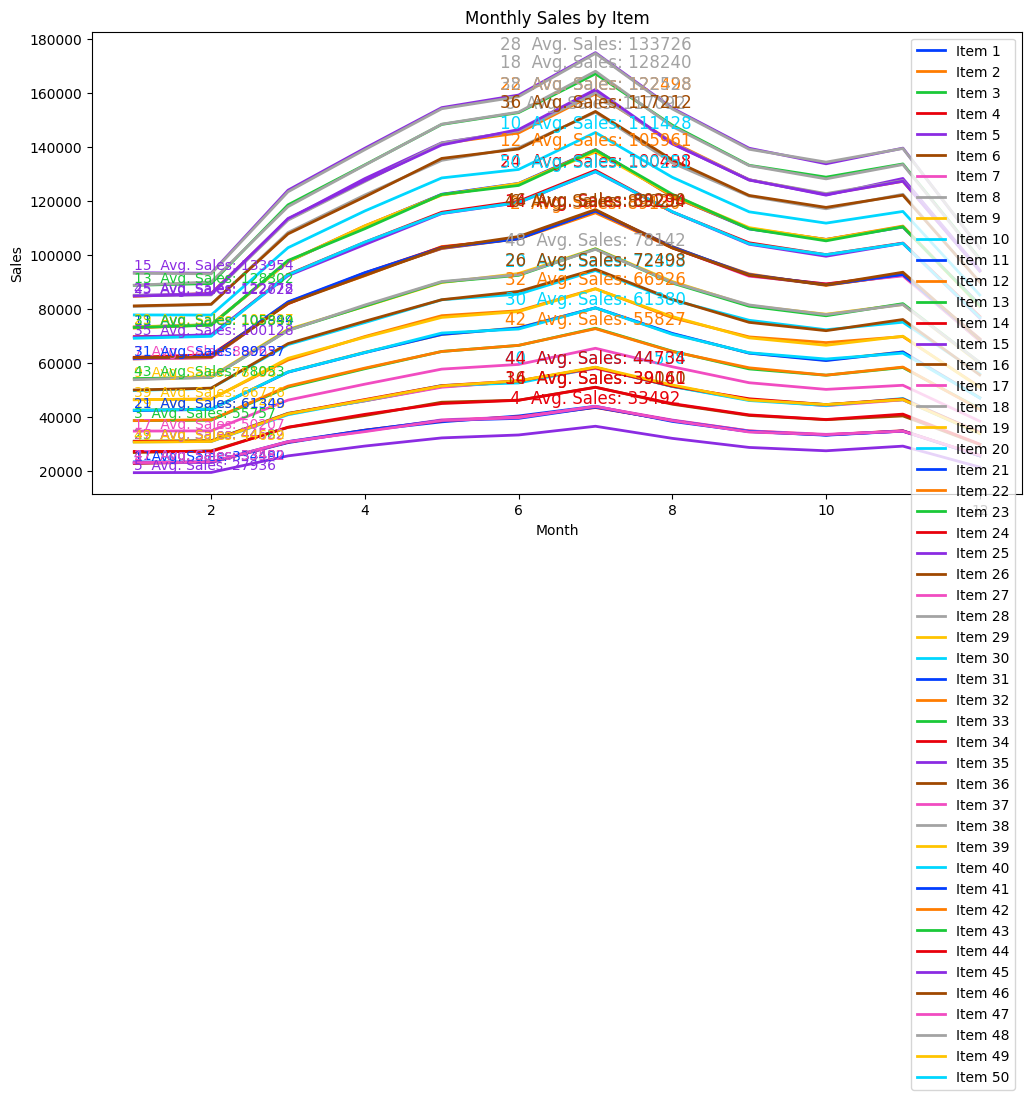

In [14]:
#group the data by year, month, and item and calculate the total sales
monthly_sales = df.groupby([df.index.year.rename('year'), df.index.month.rename('month'), 'item'])['sales'].sum().reset_index()
monthly_sales.reset_index(inplace=True)
# create aggregate sales for calculating monthly sales of each item
aggregated_sales = monthly_sales.groupby(['month', 'item'])['sales'].sum().reset_index()
# Pivot the table to have each item as a column and the months as the index
pivot_table = aggregated_sales.pivot(index='month', columns='item', values='sales')
# Get the list of items
items = pivot_table.columns
# Set the colors for the lines using sns
colors = sns.color_palette('bright', 50)
# Create the line plot
plt.figure(figsize=(12, 6))
#iterate through each item
for i, item in enumerate(items):
    plt.plot(pivot_table.index, pivot_table[item], color=colors[i % len(colors)],linewidth=2 ,label=f'Item {item}')
    average_sales = pivot_table[item].mean()
    # Add item name at the peek for even item number names and at start of the 
    if i % 2 == 0:
        plt.text(pivot_table.index[0], pivot_table[item].iloc[0], f'{item}  Avg. Sales: {average_sales:.0f}', color=colors[i % len(colors)], fontsize=10, ha='left', va='bottom')
    else:
        peak_index = np.argmax(pivot_table[item])
        plt.text(pivot_table.index[peak_index], pivot_table[item].iloc[peak_index], f'{item}  Avg. Sales: {average_sales:.0f}', color=colors[i % len(colors)], fontsize=12, ha='center', va='bottom')

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales by Item')
plt.legend()
plt.show()

Create a graph depicting TOP 5 Highest Sold Items Over the Months

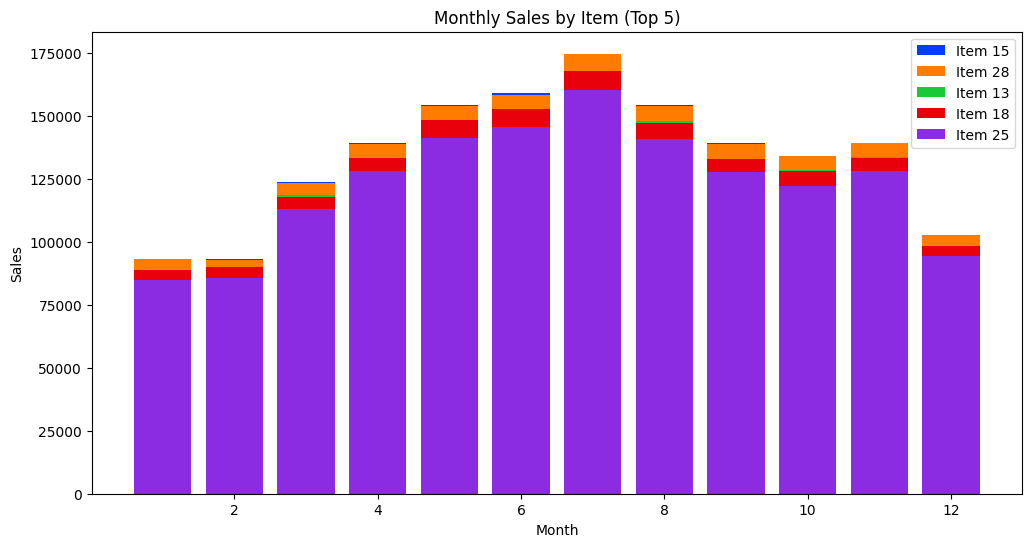

In [5]:
# get the first 5 highest sold items
top_5_items = monthly_sales.groupby('item')['sales'].sum().nlargest(5).index

# pivot table of top 5 items
pivot_table_top_5 = pivot_table[top_5_items]

# color for the bar from sns
colors = sns.color_palette('bright', 5)

# Create the bar plot
plt.figure(figsize=(12, 6))

# iterate through items in pivot table
for i, item in enumerate(pivot_table_top_5.columns):
    plt.bar(pivot_table_top_5.index, pivot_table_top_5[item], color=colors[i], label=f'Item {item}')
    plt.xlabel('Month')
    plt.ylabel('Sales')

plt.title('Monthly Sales by Item (Top 5)')
plt.legend()
plt.show()

Create a graph depicting Monthly Total sales all items of Each store (1 to 10)

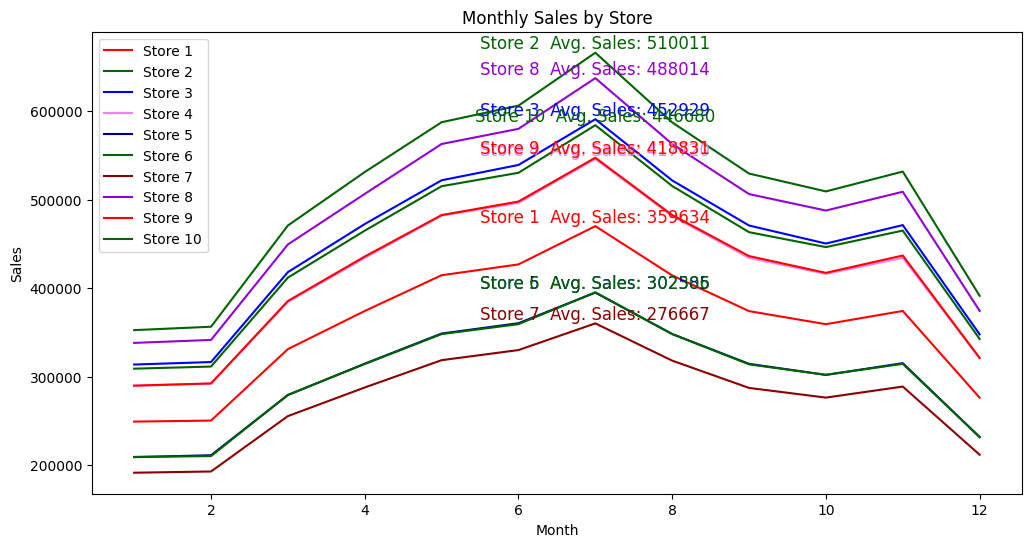

In [6]:
# Group the data by store and month, and calculate the total sales
monthly_sales_store = df.groupby([df.index.year.rename('year'), df.index.month.rename('month'), 'store'])['sales'].sum().reset_index()

# aggregated sales month wise for calculating monthly sales of items of each store
aggregated_sales_store = monthly_sales_store.groupby(['month', 'store'])['sales'].sum().reset_index()

# Pivot the table to have each store as a column and the months as the index
pivot_table_store = aggregated_sales_store.pivot(index='month', columns='store', values='sales')

# Get the list of stores from pivot table
stores = pivot_table_store.columns

# Set the colors for the line
colors = ['red', 'darkgreen', 'blue', 'violet', 'darkblue', 'darkgreen', 'darkred', 'darkviolet']
# Create the line plot

plt.figure(figsize=(12, 6))
for i, store in enumerate(stores):
    plt.plot(pivot_table_store.index, pivot_table_store[store], color=colors[i % len(colors)], label=f'Store {store}')
    average_sales = pivot_table_store[store].mean()
    peak_index = np.argmax(pivot_table_store[store])
    plt.text(pivot_table_store.index[peak_index], pivot_table_store[store].iloc[peak_index], f'Store {store}  Avg. Sales: {average_sales:.0f}', color=colors[i % len(colors)], fontsize=12, ha='center', va='bottom')

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales by Store')
plt.legend()
plt.show()

Create a graph depicting TOP 5 STORES HAVING HIGH SALES

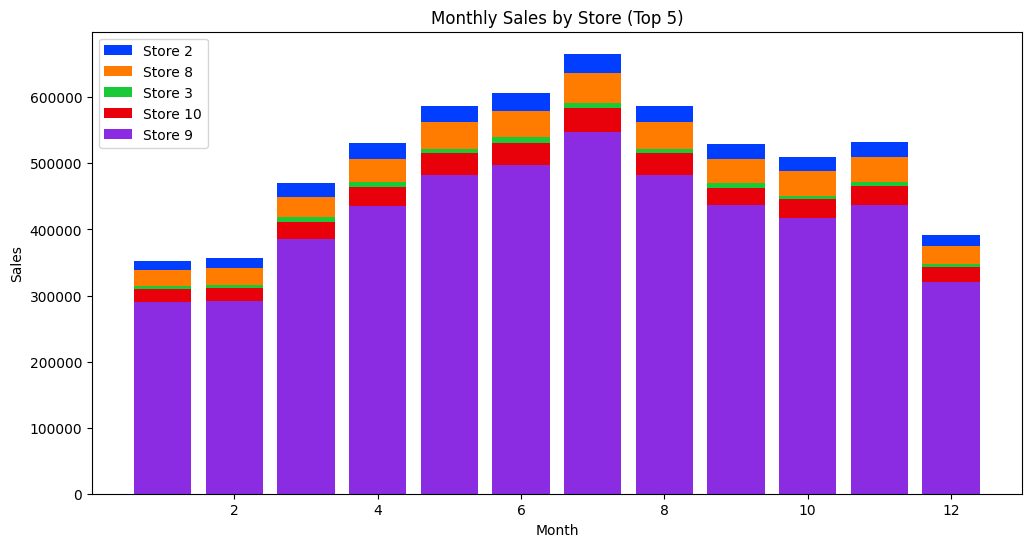

In [7]:
# Sort the stores based on total sales
top_5_stores = monthly_sales_store.groupby('store')['sales'].sum().nlargest(5).index

# Filter the pivot table to include only the top 5 stores
pivot_table_top_5 = pivot_table_store[top_5_stores]

# Generate a palette of 5 contrasting colors
colors = sns.color_palette('bright', 5)

# Create the bar plot
plt.figure(figsize=(12, 6))
for i, store in enumerate(pivot_table_top_5.columns):
    plt.bar(pivot_table_top_5.index, pivot_table_top_5[store], color=colors[i], label=f'Store {store}')
    plt.xlabel('Month')
    plt.ylabel('Sales')

plt.title('Monthly Sales by Store (Top 5)')
plt.legend()
plt.show()

Create a graph depicting Highest Sold Item in each Store

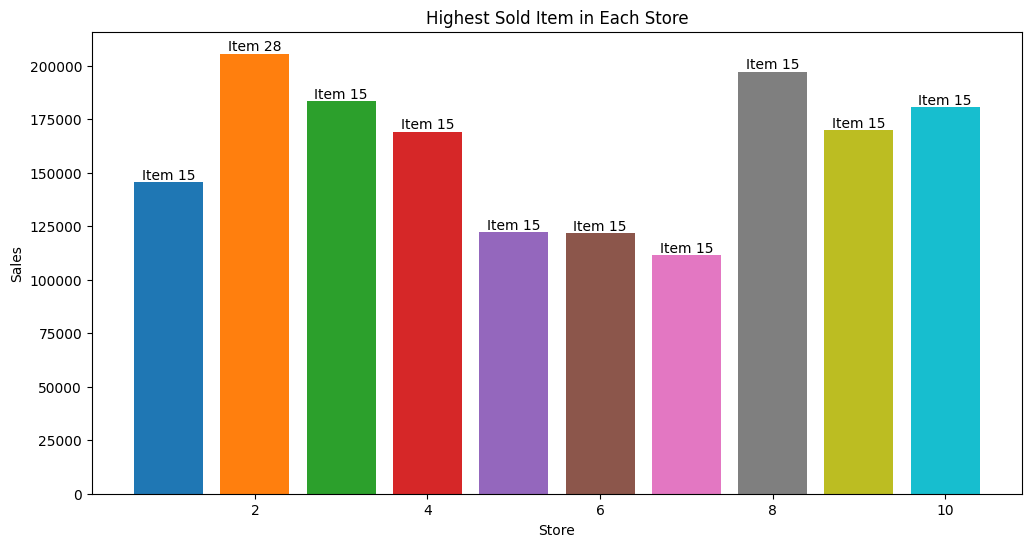

In [9]:
# Group the data by store and item and calculate the total sales
store_item_sales = df.groupby(['store', 'item'])['sales'].sum()

# Find the highest sold item in each store
highest_sold_item_per_store = store_item_sales.groupby('store').idxmax().apply(lambda x: x[1])

# Create a bar plot for the highest sold item in each store
plt.figure(figsize=(12, 6))
for store, item in highest_sold_item_per_store.items():
    sales = store_item_sales.loc[(store, item)]
    plt.bar(store, sales, edgecolor='None')
    plt.text(store, sales, f'Item {item}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Store')
plt.ylabel('Sales')
plt.title('Highest Sold Item in Each Store')
plt.show()


Create a list that containes Predicted Sales of Each Item (1 to 50) In each Store(1 to 10) that is predicted using Linear Regression based on values of Sales in columns Store and Item

In [13]:
#predict sales for a given month based on the past 1 year data
def predict_sales_for_month(month):
    
    df_reset = df.reset_index()

    # Filter the dataset for the past 1 year data based on the given month
    previous_year_data = df_reset.loc[(df_reset['date'] >= month - pd.DateOffset(years=1)) & (df_reset['date'] < month)]

    # dictionary to store the predicted sales for the given month
    predicted_sales_month = {}

    # Iterate over each item - total of 50 items
    for item in range(1, 51):
        for store in range(1, 11):  # Iterate through store numbers 1 to 10
            # Filter the dataset for the current item and store with the past 1 year data
            current_item_store_data = previous_year_data[(previous_year_data['item'] == item) & (previous_year_data['store'] == store)]

            # Prepare the data for the current item and store
            X_item_store = current_item_store_data[['store', 'item']].values

            # Get the corresponding sales data for the current item and store
            y_item_store = current_item_store_data['sales'].values

            # Create and train the linear regression model
            lin_model = LinearRegression()
            lin_model.fit(X_item_store, y_item_store)

            # Predict the sales for the current item and store for the given month based on linear regression model 
            future_data = np.array([[store, item]])  
            predicted_sales_month[(store, item)] = round(lin_model.predict(future_data)[0])

    # Print the predicted sales for each item and store for the given month
    for (store, item), sales in predicted_sales_month.items():
        print("Month:", month.strftime('%Y-%m'), "Store:", store, "Item:", item, "Predicted sales:", sales)

# Predict sales for January 2018 based on January 2017 to December 2017 data
predict_sales_for_month(pd.to_datetime('2018-01-01'))



Month: 2018-01 Store: 1 Item: 1 Predicted sales: 22
Month: 2018-01 Store: 2 Item: 1 Predicted sales: 32
Month: 2018-01 Store: 3 Item: 1 Predicted sales: 29
Month: 2018-01 Store: 4 Item: 1 Predicted sales: 26
Month: 2018-01 Store: 5 Item: 1 Predicted sales: 19
Month: 2018-01 Store: 6 Item: 1 Predicted sales: 18
Month: 2018-01 Store: 7 Item: 1 Predicted sales: 17
Month: 2018-01 Store: 8 Item: 1 Predicted sales: 30
Month: 2018-01 Store: 9 Item: 1 Predicted sales: 26
Month: 2018-01 Store: 10 Item: 1 Predicted sales: 28
Month: 2018-01 Store: 1 Item: 2 Predicted sales: 60
Month: 2018-01 Store: 2 Item: 2 Predicted sales: 84
Month: 2018-01 Store: 3 Item: 2 Predicted sales: 75
Month: 2018-01 Store: 4 Item: 2 Predicted sales: 69
Month: 2018-01 Store: 5 Item: 2 Predicted sales: 50
Month: 2018-01 Store: 6 Item: 2 Predicted sales: 51
Month: 2018-01 Store: 7 Item: 2 Predicted sales: 46
Month: 2018-01 Store: 8 Item: 2 Predicted sales: 81
Month: 2018-01 Store: 9 Item: 2 Predicted sales: 69
Month: 2018